# Worksheet

For this worksheet you'll have to first install [pygraphviz](https://pygraphviz.github.io/documentation/stable/install.html). Then run the following cell without modifying it.

In [15]:
import numpy as np
import matplotlib as mpl
from PIL import Image as im
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from networkx import DiGraph, set_node_attributes
from networkx.drawing.nx_agraph import to_agraph
from matplotlib.colors import rgb2hex

COLORS = np.array(['purple', 'blue'])
cvals  = [0, .5, 1]
colors = ['purple', 'white', 'blue']
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
CMAP = mpl.colors.LinearSegmentedColormap.from_list("", tuples, 100)

def unique_index(layer, node):
    return str(layer) + "_" + str(node)

class DenseGraph():

    def __init__(self, model):
        self.model = model
        self._graph = self._make_digraph()
        self._graph_original_copy = self._graph.copy()
        self._int_models = self._get_int_models()

    def get_graph(self):
        return self._graph


    def set_graph(self, graph=DiGraph()):
        self._graph = graph
        self._graph_original_copy = self._graph.copy()
        return


    def _reset(self):
        self._graph = self._graph_original_copy.copy()


    def _make_digraph(self):
        graph = DiGraph(nodesep='1', ranksep='1')

        for l in range(len(self.model.layers)):
            layer = self.model.layers[l]

            if type(layer) != keras.layers.Dense:
                raise ValueError("Unsupported Layer Type: %s Only Dense Layers are Supported", type(layer))

            if l == 0:
                for inp in range(layer._input_shape_arg[0]):
                    graph.add_node(
                        unique_index(l, inp),
                        shape="circle",
                        color="#3498db",
                        label=''
                    )
                inp += 1
            out = layer.units

            for h in range(out):
                if l == len(self.model.layers) - 1:
                    graph.add_node(
                        unique_index(l+1, h),
                        shape="circle",
                        color="#3498db",
                        label=''
                    )
                else:
                    graph.add_node(
                        unique_index(l+1, h),
                        shape="circle",
                        color="#2ecc71",
                        label=''
                    )
                for prev in range(inp):
                    graph.add_edge(
                        unique_index(l, prev),
                        unique_index(l + 1, h),
                        color="#B20000"
                    )
            inp = layer.units
        return graph


    def _get_int_models(self):
        """
        Creates a list of models where each model consists of all the layers
        (with matching weights and activations) in self.model up to a specified
        layer depth. This is important to get each node activation.
        """
        intermediate_models = []

        for l in range(len(self.model.layers)):
            int_model = keras.Sequential()
            inp = self.model.layers[0]._input_shape_arg[0]
            
            for prev_layer in range(l + 1):
                int_layer = self.model.layers[prev_layer]
                int_model.add(keras.layers.Dense(
                    int_layer.units,
                    input_dim=inp,
                    activation=int_layer.activation)
                )
                int_model.layers[prev_layer].set_weights(int_layer.get_weights())
                inp = int_layer.units
            int_model.compile(loss=self.model.loss)
            intermediate_models.append(int_model)

        return intermediate_models


    def _snap(self, filename):
        """
        Take snapshot image of the graph
        """
        out = to_agraph(self._graph)
        out.layout(prog='dot')
        out.draw(filename + '.png')
        return np.asarray(im.open(filename + '.png'))

    def animate_activations(self, X, filename='activations', duration=1000, x_color="#3498db", x_marker="o"):
        """
        Creates an animation of the graph activated by each data point
        """
        network_images = []

        predictions = [X]
        for i in range(len(self._int_models)):
            predictions.append(self._int_models[i].predict(X))
        predictions.append(self.model.predict(X))

        for i in range(len(X)):
            for l in range(len(self.model.layers)):
                if l == 0:
                    inp = self.model.layers[l]._input_shape_arg[0]
                else:
                    inp = self.model.layers[l-1].units
                for n in range(0, inp):
                    act = predictions[l][i][n]
                    index = unique_index(l, n)
                    if l == 0:
                        set_node_attributes(self._graph, {
                            index: {
                                'label' : " " + f"{act:.2f}" if act > 1 else " " + f"{act:.2f}".zfill(4) if act > 0 else f"{act:.2f}".zfill(4) if act > -1 else f"{act:.2f}"
                            }})
                    else:
                        # not used in the context of logistic regression
                        set_node_attributes(self._graph, {
                            index: {
                                'style': 'filled',
                                'color': str(rgb2hex(CMAP(act)))
                            }})

                for h in range(0, self.model.layers[l].units):
                    if l == len(self.model.layers) - 1:
                        act = predictions[l + 1][i][h]
                        index = unique_index(l + 1, h)

                        set_node_attributes(self._graph, {
                            index: {
                                'style': 'filled',
                                'color': str(rgb2hex(CMAP(act)))
                            }})

            network_images.append(self._snap(filename))
            self._reset()
        
        self._convert_gif(network_images, filename, duration)

        return
    
    def _convert_gif(self, imgs, filename, duration):
        stacked_images = []
        for img in imgs:
            stacked_images.append(im.fromarray(np.asarray(img)))

        stacked_images[0].save(
            filename + '.gif',
            optimize=False,
            save_all=True,
            append_images=stacked_images[1:],
            loop=0,
            duration=duration
        )

        return

    def render(self, filename='graph'):
        """
        Creates a visualization of the graph for a Sequential Dense keras model
        """
        self._snap(filename)
        return

class LR():

    def __init__(self, model):
        self.model = model

    def _snap_learning(self, X, Y, filename, func):
        h = .02
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        meshData = np.c_[xx.ravel(), yy.ravel()]

        fig, ax = plt.subplots(frameon=False)
        ax.scatter(X[:, 0], X[:, 1], color=COLORS[Y].tolist(), s=100, alpha=.9)
        Z = self.model.predict(func(meshData))
        Z = np.array([z[0] for z in Z]).reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=.4, cmap=CMAP)
        fig.savefig(filename + '.png')
        plt.close()
        return np.asarray(im.open(filename + '.png'))

    def animate_learning(self, X, Y, snap_freq=10, filename='learn', duration=1000, func=lambda x: x, **kwargs):
        images = []
        if 'epochs' in kwargs:
            epochs = kwargs['epochs']
            kwargs.pop('epochs', None)
        else:
            epochs = snap_freq

        for _ in range(int(epochs / snap_freq)):
            self.model.fit(func(X), Y, epochs=snap_freq, **kwargs)
            images.append(im.fromarray(self._snap_learning(X, Y, filename, func)))

        images[0].save(
            filename + '.gif',
            optimize=False,
            save_all=True,
            append_images=images[1:],
            loop=0,
            duration=duration
        )
        return self.model


class LR3D():

    def __init__(self, model):
        self.model = model

    def _snap_learning(self, X, Y, filename):

        weights, bias = self.model.layers[0].get_weights()
        w1, w2, w3 = weights[:, 0]
        b = bias[0]

        h = .5
        xx, yy = np.meshgrid(np.arange(-3.5, 3.5, h), np.arange(-3.5, 3.5, h))
        zz = -(w1 / w3) * xx - (w2 / w3) * yy - (b / w3)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(10, 80)
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_zlim(0, 12)
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=COLORS[Y].tolist(), s=30, alpha=.5)
        ax.plot_surface(xx, yy, zz, color='orange', alpha=0.3)
        fig.savefig(filename + '.png')
        plt.close()
        return np.asarray(im.open(filename + '.png'))

    def animate_learning(self, X, Y, snap_freq=10, filename='learn', duration=1000, **kwargs):
        images = []
        if 'epochs' in kwargs:
            epochs = kwargs['epochs']
            kwargs.pop('epochs', None)
        else:
            epochs = snap_freq

        for _ in range(int(epochs / snap_freq)):
            self.model.fit(X, Y, epochs=snap_freq, **kwargs)
            images.append(im.fromarray(self._snap_learning(X, Y, filename)))

        images[0].save(
            filename + '.gif',
            optimize=False,
            save_all=True,
            append_images=images[1:],
            loop=0,
            duration=duration
        )
        return self.model


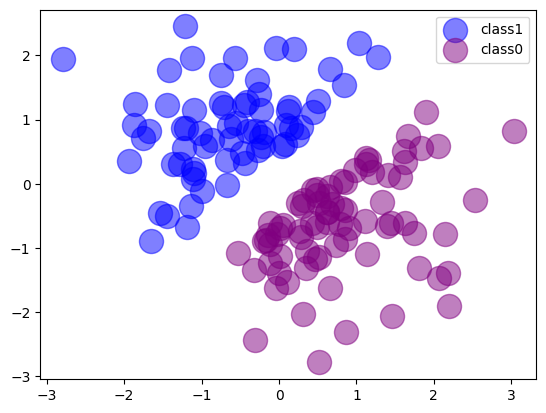

In [37]:
import sklearn.datasets as datasets

np.random.seed(1)

CENTERS = [[0, 0]]
DATA, _ = datasets.make_blobs(
        n_samples=200,
        centers=CENTERS,
        cluster_std=1,
        random_state=1
    )
w1 = 1 
w2 = -1
b = 0

X = np.array(list(filter(lambda x : w1 * x[0] + w2 * x[1] + b < -.5 or w1 * x[0] + w2 * x[1] + b > .5, DATA)))
Y = np.array([0 if w1 * x[0] + w2 * x[1] + b >= 0 else 1 for x in X])
class1 = X[Y==1]
class0 = X[Y==0]
plt.scatter(class1[:,0], class1[:,1], color=COLORS[1], s=300, alpha=.5, label='class1')
plt.scatter(class0[:,0], class0[:,1], color=COLORS[0], s=300, alpha=.5, label='class0')
plt.legend()
plt.show()

In [38]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1, input_dim=2, activation="sigmoid"))
model.compile(loss="binary_crossentropy")

obj = LR(model)
obj.animate_learning(X, Y, 10, 'lr', 100, epochs=300)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7756  
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7692
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7644


/Users/lance/Documents/BostonUniversity/CURRENT-SEMESTER/CS506-Fall2025/lecture_19/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7602
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7561
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7522
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7485
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7446 
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7411 
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7374
3335/3335 ━━━━━━━━━━━━━━━━━━━━ 1s 162us/step
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7337
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7300
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7264
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7229
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7192
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7157
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7121
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7086
Epoch 9

<Sequential name=sequential_29, built=True>

## Non-Linearly Separable

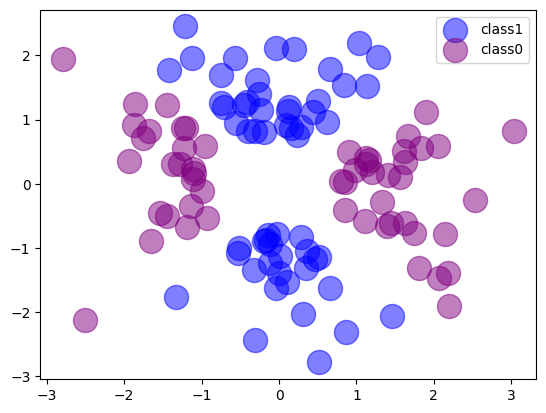

In [40]:
w1 = 1 
w2 = -1
b = 0

X = np.array(list(filter(lambda x : w1 * x[0]**2 + w2 * x[1]**2 + b < -.5 or w1 * x[0]**2 + w2 * x[1]**2 + b > .5, DATA)))
Y = np.array([0 if w1 * x[0]**2 + w2 * x[1]**2 + b >= 0 else 1 for x in X])
class1 = X[Y==1]
class0 = X[Y==0]
plt.scatter(class1[:,0], class1[:,1], color=COLORS[1], s=300, alpha=.5, label='class1')
plt.scatter(class0[:,0], class0[:,1], color=COLORS[0], s=300, alpha=.5, label='class0')
plt.legend()
plt.show()

Find new features X1 and X2 that make the data linearly separable. Animate the learned decision boundary throughout gradient descent in that feature space.

In [43]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1, input_dim=2, activation="sigmoid"))
model.compile(loss="binary_crossentropy")

transformation = lambda x : np.abs(x)

obj = LR(model)
obj.animate_learning(X, Y, 10, 'lr_tranformed', 100, epochs=200, func=transformation)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7663  
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7628
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7603
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7580
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7557
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7535
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7514
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7493
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7472
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7450
3335/3335 ━━━━━━━━━━━━━━━━━━━━ 1s 161us/step
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7432
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7412
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7395
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7376
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7358
Epoch 6

<Sequential name=sequential_33, built=True>

Animate the learned decision boundary throughout gradient descent in the original space.

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1, input_dim=2, activation="sigmoid"))
model.compile(loss="binary_crossentropy")

...

## Higher Dimension

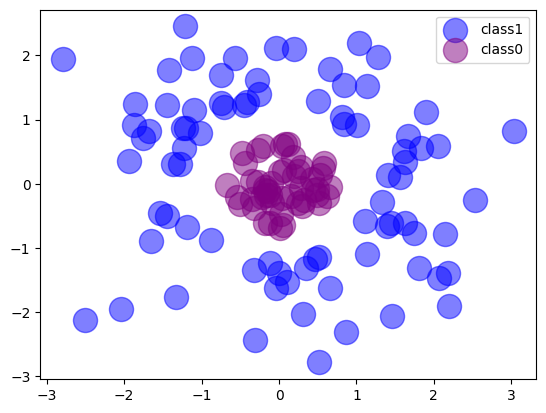

In [44]:
w1 = -1 
w2 = -1
b = 1

X = np.array(list(filter(lambda x : w1 * x[0]**2 + w2 * x[1]**2 + b < -.5 or w1 * x[0]**2 + w2 * x[1]**2 + b > .5, DATA)))
Y = np.array([0 if w1 * x[0]**2 + w2 * x[1]**2 + b >= 0 else 1 for x in X])
class1 = X[Y==1]
class0 = X[Y==0]
plt.scatter(class1[:,0], class1[:,1], color=COLORS[1], s=300, alpha=.5, label='class1')
plt.scatter(class0[:,0], class0[:,1], color=COLORS[0], s=300, alpha=.5, label='class0')
plt.legend()
plt.show()

Add a new feature to X to make the data linearly separable in 3D

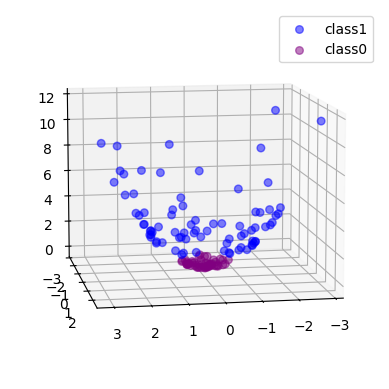

In [45]:
X = np.column_stack((X, X[:,0]**2 + X[:,1]**2))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
class1 = X[Y==1]
class0 = X[Y==0]
ax.view_init(10, 80)
ax.scatter(class1[:,0], class1[:,1], class1[:,2], color=COLORS[1], s=30, alpha=.5, label='class1')
ax.scatter(class0[:,0], class0[:,1], class0[:,2], color=COLORS[0], s=30, alpha=.5, label='class0')
ax.legend()
plt.show()

Animate the learning process through gradient descent in 3D.

In [47]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1, input_dim=3, activation="sigmoid"))
model.compile(loss="binary_crossentropy")

obj = LR3D(model)
obj.animate_learning(X, Y, 10, 'lr_tranformed', 100, epochs=400)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9869  
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9671
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9519
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9420
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9324
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9227
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9095
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9009
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8900
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8786
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8684
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8548
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8465
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8378
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8302
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

<Sequential name=sequential_35, built=True>

Come up with a new example of a complex decision boundary that either requires new features or additional features or both. Animate the learned decision boundary. Also animate the graph representation of the logistic regression model as you feed it points only from class0.

Submit both gifs in the form

In [30]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from keras.models import Sequential
from keras.layers import Dense

# 1. Generate a simple 1D dataset
np.random.seed(0)
n_samples = 50
X1 = np.random.randn(n_samples, 1) * 0.5 - 2   # class 0
X2 = np.random.randn(n_samples, 1) * 0.5 + 2   # class 1
X_1d = np.vstack([X1, X2])
Y_1d = np.hstack([np.zeros(n_samples), np.ones(n_samples)])

# 2. Build and train a simple logistic regression model
model = Sequential([Dense(1, input_dim=1, activation='sigmoid')])
model.compile(optimizer='sgd', loss='binary_crossentropy')

weights = []
losses = []

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.w = []
        self.b = []
        self.losses = []
    def on_epoch_end(self, epoch, logs=None):
        w, b = self.model.layers[0].get_weights()
        self.w.append(w[0,0])
        self.b.append(b[0])
        self.losses.append(logs['loss'])

history = LossHistory()
model.fit(X_1d, Y_1d, epochs=50, verbose=0, callbacks=[history])

# 3. Create grid of w and b values for surface
w_range = np.linspace(-8, 8, 60)
b_range = np.linspace(-10, 10, 60)
W, B = np.meshgrid(w_range, b_range)
Z = np.zeros(W.shape)

def neg_log_likelihood(w, b, X, Y):
    z = X.dot(w) + b
    pred = 1/(1 + np.exp(-z))
    nll = -np.mean(Y * np.log(pred + 1e-7) + (1 - Y) * np.log(1 - pred + 1e-7))
    return nll

for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        Z[i, j] = neg_log_likelihood(W[i, j], B[i, j], X_1d, Y_1d)

# 4. Animate the path (w,b) takes over the loss surface

# For 1D logistic regression with linearly separable data, the negative log-likelihood ('loss surface') does NOT form a smooth bowl,
# because you can always make the loss smaller by increasing |w| and |b| in the right direction. To reflect this, 
# the plotting of the loss surface must include large enough w and b ranges -- but even then, the loss surface's "bowl" is misleading 
# past the point of perfect separation, where the loss approaches zero asymptotically but the surface becomes flat or heads offboard.

# It is important to realize that when the data is perfectly separable, the minimum loss is not at a finite parameter value.
# The 3D plot will only show a 'bowl' due to the clipping at the edges of w,b ranges;
# in truth, for perfectly separable 1D data, loss decreases monotonically as the linear boundary gets steeper.

fig = plt.figure(figsize=(14, 6))
ax_loss = fig.add_subplot(121, projection='3d')
ax_decision = fig.add_subplot(122)

def update(epoch):
    # 3D Loss Surface subplot
    ax_loss.cla()
    ax_loss.plot_surface(W, B, Z, cmap='viridis', alpha=0.7, linewidth=0, antialiased=False)
    # Show the optimization path up to current epoch
    ax_loss.plot(history.w[:epoch+1], history.b[:epoch+1], history.losses[:epoch+1], color='r', marker='o', linewidth=1, zorder=9)
    curr_w = history.w[epoch]
    curr_b = history.b[epoch]
    curr_loss = history.losses[epoch]
    ax_loss.scatter(curr_w, curr_b, curr_loss, color='k', s=70, zorder=10)
    ax_loss.set_xlabel('w')
    ax_loss.set_ylabel('b')
    ax_loss.set_zlabel('Negative Log Likelihood')
    ax_loss.set_title(f"Loss Surface (Epoch {epoch+1})")
    ax_loss.view_init(30, 45 + epoch)
    # No minimum exists in the finite grid if the data is perfectly separable

    # 1D Decision Boundary subplot
    ax_decision.cla()
    ax_decision.scatter(X_1d[Y_1d == 0], Y_1d[Y_1d == 0], color='blue', label='Class 0')
    ax_decision.scatter(X_1d[Y_1d == 1], Y_1d[Y_1d == 1], color='orange', label='Class 1')
    x_plot = np.linspace(X_1d.min()-0.5, X_1d.max()+0.5, 200)
    y_pred_epoch = 1 / (1 + np.exp(-(curr_w * x_plot + curr_b)))
    ax_decision.plot(x_plot, y_pred_epoch, color='red', label='Model Output', linewidth=2)
    ax_decision.axhline(0.5, color='gray', linestyle='--', linewidth=1)
    ax_decision.set_xlabel('Input x')
    ax_decision.set_ylabel('Predicted Probability')
    ax_decision.set_ylim(-0.1, 1.1)
    ax_decision.set_title(f"Decision Boundary (Epoch {epoch+1})")
    ax_decision.legend(loc="best")

num_epochs = len(history.w)
ani = animation.FuncAnimation(fig, update, frames=num_epochs, interval=200, repeat=False)

# Save as GIF
ani.save('neg_log_likelihood_1d_wrong.gif', writer='pillow')
plt.close(fig)  # Prevent display in the notebook

In [53]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K
import tensorflow as tf

# Define piecewise linear activation: 0 -> linear -> 1
def piecewise_linear(x):
    """
    Piecewise linear function:
    - 0 if x < 0
    - x if 0 <= x <= 1
    - 1 if x > 1
    """
    return tf.clip_by_value(x, 0.0, 1.0)

# 1. Generate a simple 1D dataset
np.random.seed(0)
n_samples = 50
X1 = np.random.randn(n_samples, 1) * 0.5 - 2   # class 0
X2 = np.random.randn(n_samples, 1) * 0.5 + 2  # class 1
X_1d = np.vstack([X1, X2])
Y_1d = np.hstack([np.zeros(n_samples), np.ones(n_samples)])

# 2. Build and train a model with piecewise linear activation
model = Sequential([
    Dense(1, input_dim=1),
    Activation(piecewise_linear)
])
model.compile(optimizer='sgd', loss='binary_crossentropy')

weights = []
losses = []

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.w = []
        self.b = []
        self.losses = []
    def on_epoch_end(self, epoch, logs=None):
        w, b = self.model.layers[0].get_weights()
        self.w.append(w[0,0])
        self.b.append(b[0])
        self.losses.append(logs['loss'])

history = LossHistory()
model.fit(X_1d, Y_1d, epochs=100, verbose=0, callbacks=[history])

# 3. Create grid of w and b values for surface
w_range = np.linspace(-20, 20, 100)
b_range = np.linspace(-20, 20, 100)
W, B = np.meshgrid(w_range, b_range)
Z = np.zeros(W.shape)

def piecewise_linear_np(x):
    """NumPy version of piecewise linear activation for loss calculation"""
    return np.clip(x, 0.0, 1.0)

def neg_log_likelihood(w, b, X, Y):
    # For 1D data, X is (n_samples, 1), w is scalar, so use element-wise multiplication
    z = X.flatten() * w + b
    pred = piecewise_linear_np(z)  # Use piecewise linear instead of sigmoid
    nll = -np.mean(Y * np.log(pred + 1e-7) + (1 - Y) * np.log(1 - pred + 1e-7))
    return nll

for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        Z[i, j] = neg_log_likelihood(W[i, j], B[i, j], X_1d, Y_1d)

# 4. Animate the path (w,b) takes over the loss surface

# For 1D logistic regression with linearly separable data, the negative log-likelihood ('loss surface') does NOT form a smooth bowl,
# because you can always make the loss smaller by increasing |w| and |b| in the right direction. To reflect this, 
# the plotting of the loss surface must include large enough w and b ranges -- but even then, the loss surface's "bowl" is misleading 
# past the point of perfect separation, where the loss approaches zero asymptotically but the surface becomes flat or heads offboard.

# It is important to realize that when the data is perfectly separable, the minimum loss is not at a finite parameter value.
# The 3D plot will only show a 'bowl' due to the clipping at the edges of w,b ranges;
# in truth, for perfectly separable 1D data, loss decreases monotonically as the linear boundary gets steeper.

fig = plt.figure(figsize=(14, 6))
ax_loss = fig.add_subplot(121, projection='3d')
ax_decision = fig.add_subplot(122)

def update(epoch):
    # 3D Loss Surface subplot
    ax_loss.cla()
    ax_loss.plot_surface(W, B, Z, cmap='viridis', alpha=0.7, linewidth=0, antialiased=False)
    # Show the optimization path up to current epoch
    if epoch > 0:
        ax_loss.plot(history.w[:epoch+1], history.b[:epoch+1], history.losses[:epoch+1], color='r', marker='o', linewidth=2, markersize=4, zorder=9)
    curr_w = history.w[epoch]
    curr_b = history.b[epoch]
    curr_loss = history.losses[epoch]
    ax_loss.scatter([curr_w], [curr_b], [curr_loss], color='k', s=100, zorder=10)
    ax_loss.set_xlabel('w')
    ax_loss.set_ylabel('b')
    ax_loss.set_zlabel('Negative Log Likelihood')
    ax_loss.set_title(f"Loss Surface (Epoch {epoch+1})")
    ax_loss.set_xlim(w_range.min(), w_range.max())
    ax_loss.set_ylim(b_range.min(), b_range.max())
    ax_loss.view_init(30, 45 + epoch * 0.5)  # Slower rotation
    # No minimum exists in the finite grid if the data is perfectly separable

    # 1D Decision Boundary subplot
    ax_decision.cla()
    ax_decision.scatter(X_1d[Y_1d == 0].flatten(), Y_1d[Y_1d == 0], color='blue', label='Class 0', s=50, alpha=0.7)
    ax_decision.scatter(X_1d[Y_1d == 1].flatten(), Y_1d[Y_1d == 1], color='orange', label='Class 1', s=50, alpha=0.7)
    x_plot = np.linspace(X_1d.min()-0.5, X_1d.max()+0.5, 200)
    z_plot = curr_w * x_plot + curr_b
    y_pred_epoch = piecewise_linear_np(z_plot)  # Use piecewise linear instead of sigmoid
    ax_decision.plot(x_plot, y_pred_epoch, color='red', label='Model Output', linewidth=2)
    ax_decision.axhline(0.5, color='gray', linestyle='--', linewidth=1, label='Decision Threshold')
    # Mark the decision boundary (where output = 0.5)
    # For piecewise linear: output = 0.5 when z = 0.5, so w*x + b = 0.5
    if abs(curr_w) > 1e-6:  # Avoid division by zero
        decision_x = (0.5 - curr_b) / curr_w
        ax_decision.axvline(decision_x, color='green', linestyle='--', linewidth=1, alpha=0.7, label='Decision Boundary')
    ax_decision.set_xlabel('Input x')
    ax_decision.set_ylabel('Predicted Probability')
    ax_decision.set_ylim(-0.1, 1.1)
    ax_decision.set_title(f"Decision Boundary (Epoch {epoch+1})")
    ax_decision.legend(loc="best")

num_epochs = len(history.w)
ani = animation.FuncAnimation(fig, update, frames=num_epochs, interval=200, repeat=False)

# Save as GIF
ani.save('neg_log_likelihood_1d.gif', writer='pillow')
plt.close(fig)  # Prevent display in the notebook

/Users/lance/Documents/BostonUniversity/CURRENT-SEMESTER/CS506-Fall2025/lecture_19/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.linear_model import SGDClassifier
import keras
from keras.models import Sequential
from keras.layers import Dense

# 1. Generate linearly separable 2D dataset
np.random.seed(42)
n_samples = 50
# Create two well-separated classes
X1 = np.random.randn(n_samples, 2) * 0.5 + np.array([-1, -1])  # class 0
X2 = np.random.randn(n_samples, 2) * 0.5 + np.array([1, 1])    # class 1
X = np.vstack([X1, X2])
Y = np.hstack([np.zeros(n_samples), np.ones(n_samples)])

# 2. Train SVM using SGDClassifier with hinge loss (to track progress)
svm_history = {'w': [], 'b': [], 'iterations': []}
svm_model = SGDClassifier(loss='hinge', learning_rate='constant', eta0=0.01, 
                          max_iter=1, warm_start=True, random_state=42)

# Train SVM incrementally
for i in range(100):
    svm_model.partial_fit(X, Y, classes=[0, 1])
    coef = svm_model.coef_[0]
    intercept = svm_model.intercept_[0]
    svm_history['w'].append(coef.copy())
    # intercept is already a scalar (float), not an array
    svm_history['b'].append(float(intercept))
    svm_history['iterations'].append(i + 1)

# 3. Train Logistic Regression with Keras
lr_model = Sequential([Dense(1, input_dim=2, activation='sigmoid')])
lr_model.compile(optimizer='sgd', loss='binary_crossentropy')

class LRHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.w = []
        self.b = []
        self.iterations = []
    def on_epoch_end(self, epoch, logs=None):
        w, b = self.model.layers[0].get_weights()
        self.w.append(w.copy())
        self.b.append(b[0])
        self.iterations.append(epoch + 1)

lr_history = LRHistory()
lr_model.fit(X, Y, epochs=200, verbose=0, callbacks=[lr_history])

# 4. Create animation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

def plot_decision_boundary(ax, w, b, X, Y, title):
    ax.clear()
    
    # Plot data points
    ax.scatter(X[Y==0, 0], X[Y==0, 1], color='blue', s=50, alpha=0.7, label='Class 0')
    ax.scatter(X[Y==1, 0], X[Y==1, 1], color='orange', s=50, alpha=0.7, label='Class 1')
    
    # Plot decision boundary: w[0]*x + w[1]*y + b = 0
    # Rearranged: y = -(w[0]*x + b) / w[1]
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    if abs(w[1]) > 1e-6:  # Avoid division by zero
        x_plot = np.linspace(x_min, x_max, 100)
        y_plot = -(w[0] * x_plot + b) / w[1]
        # Clip to plot bounds
        y_plot = np.clip(y_plot, y_min, y_max)
        ax.plot(x_plot, y_plot, 'r-', linewidth=2, label='Decision Boundary')
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_title(title)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

def update(frame):
    # Determine which iteration to show
    max_svm_iter = len(svm_history['w'])
    max_lr_iter = len(lr_history.w)
    
    # Show progress proportionally
    svm_idx = min(int(frame * max_svm_iter / max(max_svm_iter, max_lr_iter)), max_svm_iter - 1)
    lr_idx = min(int(frame * max_lr_iter / max(max_svm_iter, max_lr_iter)), max_lr_iter - 1)
    
    # Plot SVM
    if svm_idx < len(svm_history['w']):
        plot_decision_boundary(ax1, svm_history['w'][svm_idx], svm_history['b'][svm_idx], 
                               X, Y, f'SVM (Iteration {svm_history["iterations"][svm_idx]})')
    
    # Plot Logistic Regression
    if lr_idx < len(lr_history.w):
        w_lr = lr_history.w[lr_idx].flatten()
        plot_decision_boundary(ax2, w_lr, lr_history.b[lr_idx], 
                               X, Y, f'Logistic Regression (Epoch {lr_history.iterations[lr_idx]})')

# Create animation
num_frames = max(len(svm_history['w']), len(lr_history.w))
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=100, repeat=True)

# Save as GIF
ani.save('svm_lr_comparison.gif', writer='pillow', fps=10)
plt.close(fig)
print("Animation saved as 'svm_lr_comparison.gif'")
# Print the final parameters for SVM
print("Final SVM parameters:")
print("w:", svm_history['w'][-1])
print("b:", svm_history['b'][-1])

# Print the final parameters for Logistic Regression
print("Final Logistic Regression parameters:")
print("w:", lr_history.w[-1])
print("b:", lr_history.b[-1])


/Users/lance/Documents/BostonUniversity/CURRENT-SEMESTER/CS506-Fall2025/lecture_19/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Animation saved as 'svm_lr_comparison.gif'
Final SVM parameters:
w: [1.26444808 1.32329078]
b: 0.07
Final Logistic Regression parameters:
w: [[1.0623572]
 [1.4617202]]
b: 0.016124265
